# RetinaNet 기반 Object Detection 모델 구현

<br>

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; RetinaNet을 이용하여 특정 조건을 만족하는 자율 주행 시스템을 구현하였다. 학습 데이터셋은 Tensorflow에서 제공하는 'KITTI' 데이터셋을 사용하였다. RetinaNet의 Backbone 모델은 ResNet-50을 사용하였다. 옵티마이저는 SGD를 이용하였으며 모멘텀은 0.9로 설정하였다. 배치 크기는 8로 하였으며 총 4회 학습하였으며, 검증 데이터셋에 대한 손실 값은 1.071임을 확인하였다. 최종 추론 단계에서는 10장의 이미지를 사용하였으며 모두 조건을 충족하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 프로젝트는 RetinaNet을 이용하여 특정 조건을 만족하는 자율 주행 시스템을 구현하는 것을 목표로 합니다. 조건은 (1) 사람이 한 명 이상 있는 경우 정지, (2) 차량의 크기(width or height)가 300px 이상인 경우 정지 입니다. Tensorflow에서 제공하는 'KITTI' 데이터셋을 이용하여 모델을 학습하여 이를 바탕으로 시스템을 구현합니다.
</span><br><br>

> _1. 서론_
>
> _2. 데이터 분석_
>
> _3. 데이터 전처리_
>
> _4. 모델 생성 및 학습_
>
> _5. 모델 평가_

<br><br>

_**<span style="color:red">※본 예제는 LMS 클라우드가 아닌 로컬에서 진행되어 학습 속도 및 결과 등이 상이할 수 있습니다.</span>**_
***

#### 필요 라이브러리 호출
***
+ 예제에 필요한 라이브러리 호출
***

In [1]:
import cv2
import os, copy
import numpy as np


import tensorflow as tf
import tensorflow.keras as K
import tensorflow_datasets as tfds


import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

<br>

#### 하이퍼파라미터 및 구성(Configuration) 정의
***
+ 예제에 필요한 구성 정의
***

In [2]:
EPOCHS = 4
BATCH_SIZE = 8

DATASET_DIR = '../datasets/gd_06/'
MODEL_DIR = os.path.join('../ignore/gd06/', 'checkpoints')
MODEL_PATH = os.path.join(MODEL_DIR, f'weights_epoch_{EPOCHS}')

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델에 입력되는 데이터를 확인합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다. 본 예제에서 사용하는 데이터는 Tensorflow에서 제공하는 도로 이미지로 구성된 `KITTI` 데이터셋 입니다. 학습 데이터 6,347개, 테스트 데이터 711개입니다.
</span>

***

<br>

#### 데이터셋 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러오기


+ Tensorflow에서 제공하는 도로 이미지로 구성된 `KITTI` 데이터셋 사용
***

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti', data_dir=DATASET_DIR, split=('train', 'test'), shuffle_files=True, with_info=True
)
NUM_CLASSES = ds_info.features["objects"]["type"].num_classes

<br>

#### 데이터셋 기본 정보 확인
***
+ 학습 데이터 6,347개, 테스트 데이터 711개


+ 입력 데이터는 `int8` 형식의 사이즈가 다른 컬러 이미지


+ 정답 데이터로 객체 클래스에 해당하는 `type`과 객체 경계 박스 `bbox`를 사용
***

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='../datasets/gd_06/kitti\\3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float3

<br>

#### 데이터셋 샘플 시각화
***
+ 데이터셋 이미지를 시각화


+ 도로 이미지를 확인 가능
***

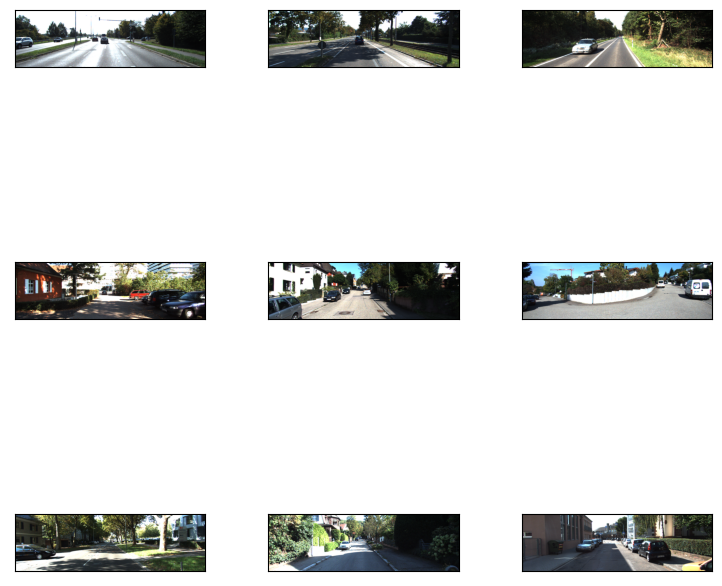

In [5]:
_ = tfds.show_examples(ds_train, ds_info)

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 네트워크 학습 전, 데이터셋을 네트워크에 입력 가능한 크기로 변경하거나 학습 효율을 위해 데이터셋을 가공하는 데이터 전처리를 수행합니다. 'KITTI' 데이터셋의 경우, 입력되는 이미지의 크기를 변경할 경우 Anchor Box 또한 변경되므로 이를 고려하여 전처리를 수행합니다. 학습 데이터와 검증 데이터를 구분하여 각각 전처리를 수행하였습니다.
</span>

***

#### 데이터셋 전처리 함수 정의
***
+ 입력 이미지 및 target 데이터 전처리 함수 정의
***

In [6]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
    return image, boxes
    
def resize_and_pad_image(image, training=True):
    min_side, max_side = 800.0, 1333.0
    min_side_range = (640, 1024)
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

def convert_to_xywh(boxes):
    xywh = tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]], axis=-1)
    return xywh

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack([
        bbox[:, 0] * image_shape[1],
        bbox[:, 1] * image_shape[0],
        bbox[:, 2] * image_shape[1],
        bbox[:, 3] * image_shape[0]],
        axis=-1
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

<br>

#### Anchor Box 생성 클래스 정의
***
+ 실제 라벨을 `Anchor Box`에 맞추는 클래스 정의
***

In [9]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            ) for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = self.__compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = K.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
    def __convert_to_corners(self, boxes):
        corners = tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1)
        return corners
    
    def __compute_iou(self, boxes1, boxes2):
        boxes1_corners = self.__convert_to_corners(boxes1)
        boxes2_corners = self.__convert_to_corners(boxes2)
        lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
        rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
        intersection = tf.maximum(0.0, rd - lu)
        intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
        boxes1_area = boxes1[:, 2] * boxes1[:, 3]
        boxes2_area = boxes2[:, 2] * boxes2[:, 3]
        union_area = tf.maximum(
            boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
        )
        return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

<br>

#### 데이터 전처리 및 증강 수행
***
+ 학습 데이터셋과 검증 데이터셋에 대해 전처리 수행
***

In [10]:
label_encoder = LabelEncoder()
autotune = tf.data.AUTOTUNE

ds_train = ds_train.map(preprocess_data, num_parallel_calls=autotune)
ds_train = ds_train.shuffle(8 * BATCH_SIZE)
ds_train = ds_train.padded_batch(batch_size=BATCH_SIZE, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
ds_train = ds_train.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_train = ds_train.prefetch(autotune)

ds_val = ds_test.map(preprocess_data, num_parallel_calls=autotune)
ds_val = ds_val.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
ds_val = ds_val.map(label_encoder.encode_batch, num_parallel_calls=autotune)
ds_val = ds_val.prefetch(autotune)

<br>

## 4. 모델 생성 및 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; ResNet-50을 Backbone으로 하는 RetinaNet을 사용하였습니다.옵티마이저는 SGD를 사용하고 모멘텀은 0.9로 설정하였습니다.배치 크기 8로 총 4회 학습하였으며 검증 데이터셋에 대한 최종 손실 값은 1.071입니다.
</span>

***

#### 모델 클래스 정의
***
+ `ResNet-50`을 Backbone으로 하는 RetinaNet 구현
***

In [13]:
class FeaturePyramid(K.layers.Layer):
    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = K.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = K.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = K.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = K.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = K.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = K.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = K.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = K.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = K.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

    
class RetinaNet(K.Model):
    def __init__(self, num_classes):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(self.__get_backbone())
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = self.__build_head(9 * num_classes, prior_probability)
        self.box_head = self.__build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs, box_outputs = [], []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(tf.reshape(self.cls_head(feature), [N, -1, self.num_classes]))
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)
    
    def __get_backbone(self):
        backbone = K.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
        c3_output, c4_output, c5_output = [
            backbone.get_layer(layer_name).output
            for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
        ]
        return K.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])
    
    def __build_head(self, output_filters, bias_init):
        head = K.Sequential([K.Input(shape=[None, None, 256])])
        kernel_init = K.initializers.RandomNormal(0.0, 0.01)
        for _ in range(4):
            head.add(K.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
            head.add(K.layers.ReLU())

        head.add(K.layers.Conv2D(
            output_filters, 3, 1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init
        ))
        return head

<br>

#### 손실 함수 정의
***
+ RetinaNet 학습을 위한 손실 함수 정의


+ Box Regression과 Classification을 위한 손실 함수를 개별적으로 정의
***

In [14]:
class RetinaNetBoxLoss(K.losses.Loss):
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(K.losses.Loss):
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(K.losses.Loss):
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss
    
def model_fit(model, trainset, testset, model_path):
    callbacks_list = [
        K.callbacks.ModelCheckpoint(
            filepath=model_path,
            monitor="val_loss",
            save_best_only=False,
            save_weights_only=True,
            verbose=1
        )
    ]
    return model.fit(trainset, validation_data=testset, epochs=EPOCHS, callbacks=callbacks_list)

<br>

#### 모델 학습
***
+ 옵티마이저는 SGD를 사용하고 모멘텀은 0.9로 설정


+ 배치 크기 8로 총 4회 학습
***

In [18]:
model = RetinaNet(NUM_CLASSES)

learning_rate_fn = K.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[125, 250, 500, 240000, 360000],
    values=[2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
)
optimizer = K.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
loss_fn = RetinaNetLoss(NUM_CLASSES)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

# history = model_fit(model, ds_train, ds_val, MODEL_PATH)

Epoch 1/4
793/793 [==============================] - 783s 960ms/step - loss: 2.8130 - accuracy: 0.2504 - val_loss: 1.8525 - val_accuracy: 0.1991

Epoch 00001: saving model to ../ignore/gd06/checkpoints\weights_epoch_4
Epoch 2/4
793/793 [==============================] - 773s 973ms/step - loss: 1.2124 - accuracy: 0.2708 - val_loss: 1.3114 - val_accuracy: 0.2435

Epoch 00002: saving model to ../ignore/gd06/checkpoints\weights_epoch_4
Epoch 3/4
793/793 [==============================] - 755s 951ms/step - loss: 0.8482 - accuracy: 0.2507 - val_loss: 1.1429 - val_accuracy: 0.2695

Epoch 00003: saving model to ../ignore/gd06/checkpoints\weights_epoch_4
Epoch 4/4
793/793 [==============================] - 780s 982ms/step - loss: 0.6710 - accuracy: 0.2493 - val_loss: 1.0717 - val_accuracy: 0.2580

Epoch 00004: saving model to ../ignore/gd06/checkpoints\weights_epoch_4


<br>

## 5. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 학습한 모델을 바탕으로 추론을 수행합니다. 프로젝트의 목표는 특정 조건을 만족하는 '자율 주행 시스템' 함수를 구현하는 것입니다. 조건은 (1) 사람이 한 명 이상 있는 경우 정지, (2) 차량의 크기(width or height)가 300px 이상인 경우 정지 입니다. 10장의 추론 이미지에 대해 조건을 모두 만족하는 시스템을 구현하였습니다.
</span>

***

#### 모델 불러오기
***
+ 앞서 학습한 모델 불러오기
***

In [19]:
# model.load_weights(tf.train.latest_checkpoint(MODEL_DIR))

<br>

#### 추론 모델 클래스 및 함수 정의
***
+ 추론을 위한 모델 클래스 및 함수 정의
***

In [24]:
class DecodePredictions(tf.keras.layers.Layer):
    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = self.__convert_to_corners(boxes)
        return boxes_transformed
    
    def __convert_to_corners(self, boxes):
        corners = tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0], axis=-1)
        return corners

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )
    
def get_model():
    input_layer =K.Input(shape=[None, None, 3], name="image")
    predictions = model(input_layer, training=False)
    detections = DecodePredictions(confidence_threshold=0.5)(input_layer, predictions)
    inference_model = K.Model(inputs=input_layer, outputs=detections)
    return inference_model

<br>

#### 추론 지원 함수 정의
***
+ 추론 결과 시각화 함수 및 입력 이미지 전처리 함수 정의
***

In [55]:
def visualize_detections(image, boxes, classes, scores, linewidth=1, color=[0, 0, 1]):
    image = np.array(image, dtype=np.uint8)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle([origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    return plt

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = K.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

def get_detect_info(img):
    int2str = ds_info.features["objects"]["type"].int2str
    img = tf.cast(img, dtype=tf.float32)
    input_img, ratio = prepare_image(img)
    detections = inf_model.predict(input_img)
    num_detections = detections.valid_detections[0]

    class_names = tuple(int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections])
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    scores = detections.nmsed_scores[0][:num_detections]
    return img, boxes, class_names, scores

<br>

#### 자율주행 시스템 함수 정의 및 추론 수행
***
+ 앞서 학습한 모델을 바탕으로 특정 조건을 만족하는 함수를 정의


+ 조건은 다음과 같음

    _(1) 사람이 한 명 이상 있는 경우 정지_
    
    _(2) 차량의 크기(width or height)가 300px 이상인 경우_

<br>

+ 10장의 추론 이미지에 대한 추론 수행
***

pred: Go  , answer: Go  , score: 10
pred: Go  , answer: Go  , score: 20
pred: Go  , answer: Go  , score: 30
pred: Go  , answer: Go  , score: 40
pred: Go  , answer: Go  , score: 50
pred: Stop, answer: Stop, score: 60
pred: Stop, answer: Stop, score: 70
pred: Stop, answer: Stop, score: 80
pred: Stop, answer: Stop, score: 90
pred: Stop, answer: Stop, score: 100

***** 100점입니다. *****


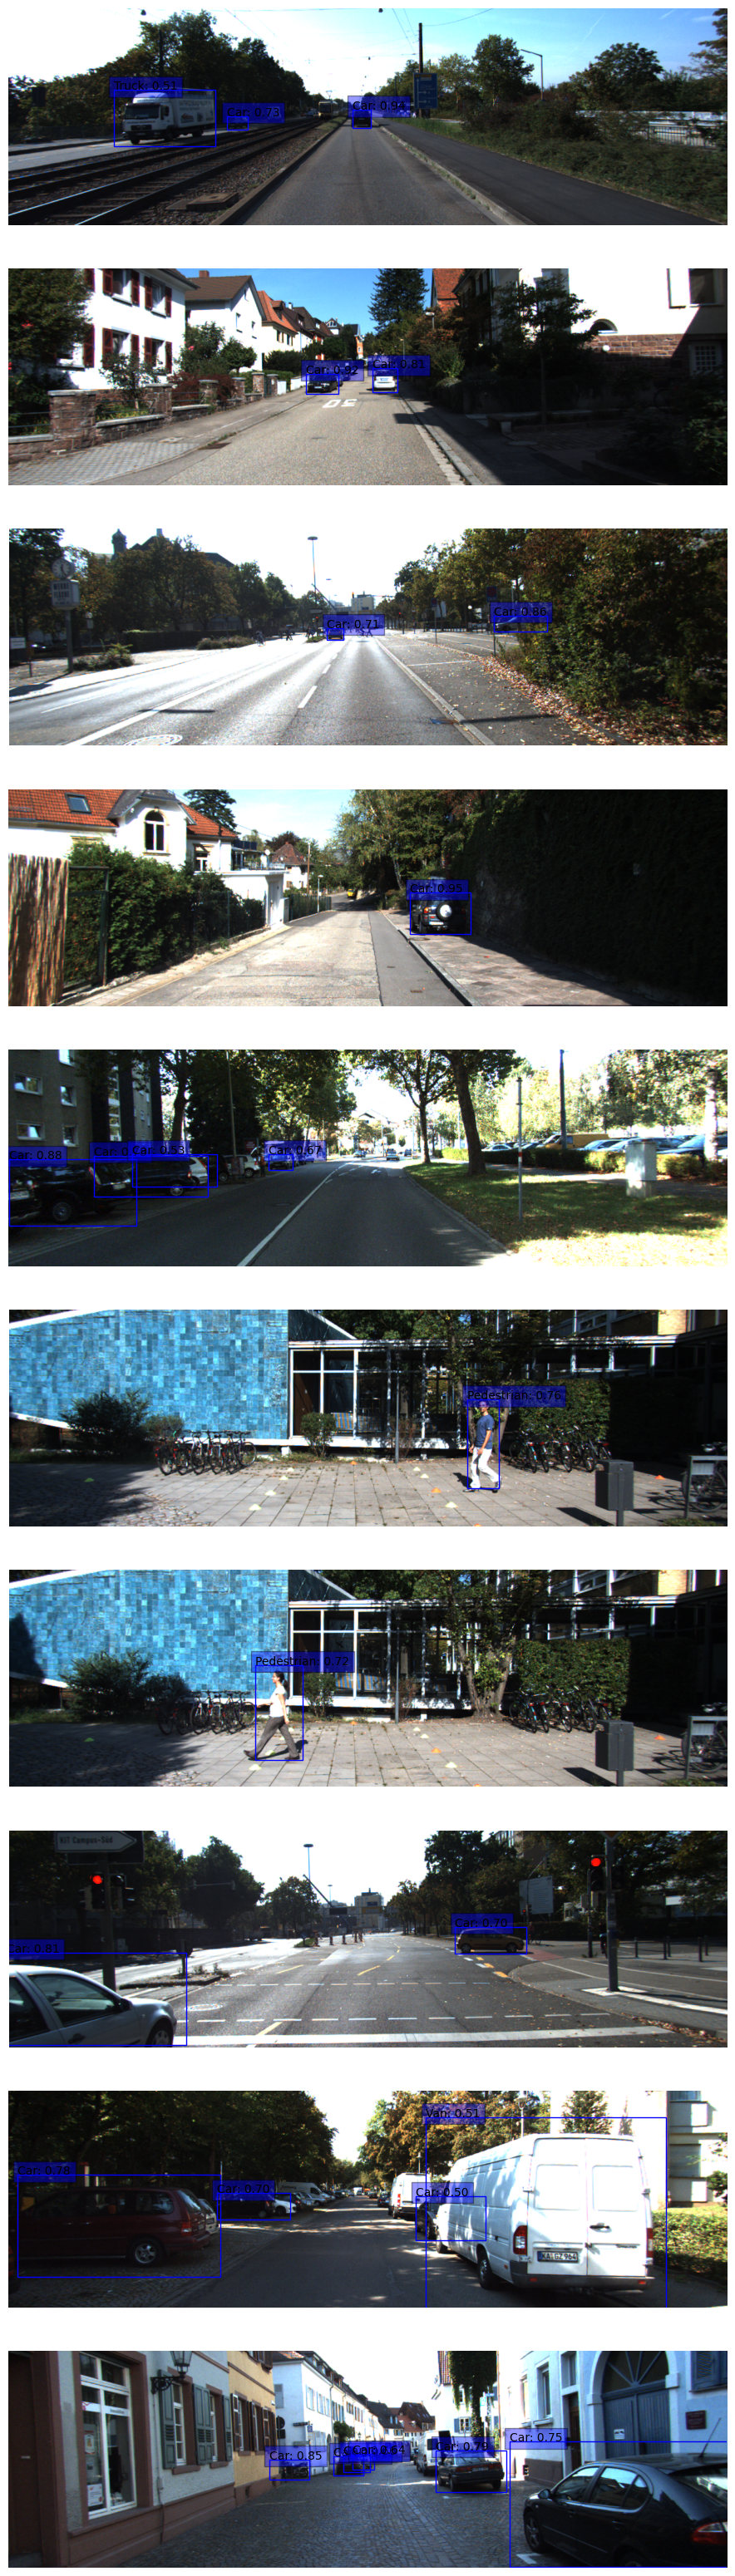

In [101]:
def self_drive_assist(img_path, size_limit=300):
    img = Image.open(img_path).convert('RGB')
    
    img = tf.convert_to_tensor(np.array(img), dtype=tf.float32)
    img, boxes, class_names, scores = get_detect_info(img)
    
    _ = visualize_detections(img, boxes, class_names, scores)
    
    for (x_a, y_a, x_b, y_b), cls in zip(boxes, class_names):
        if 'P' in cls: #person Check
            return 'Stop'
        if (x_b - x_a) >= size_limit or  (y_b - y_a) >= size_limit: #Vichle Check
            return 'Stop'
    return 'Go'

def test_system():
    test_paths = glob.glob('./data/*')
    score = 0
    
    plt.figure(figsize=(13, 40))
    for idx, path in enumerate(test_paths, 1):
        answer = 'Stop' if 'stop' in path else 'Go'
        plt.subplot(10, 1, idx)
        pred = self_drive_assist(path)
        if pred == answer:
            score += 10
        print(f'pred: {pred:4}, answer: {answer:4}, score: {score:2}')
    print(f"\n***** {score}점입니다. *****")
    plt.show()

    
inf_model = get_model()
test_system()

<br>

## 5. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; RetinaNet을 이용하여 특정 조건을 만족하는 자율 주행 시스템을 구현하였습니다. RetinaNet의 Backbone으로는 ResNet-50을 사용하였습니다. 모델 학습 데이터로는 'KITTI' 데이터셋을 사용하였습니다. 학습 시, 배치 크기를 8로 하여 총 4회 학습하였습니다. 검증 데이터셋에 대한 손실 값은 1.071입니다. 최종적으로 추론 이미지 10장 모두 올바르게 추론 한 것을 확인하였습니다.
</span>

***

<br>

#### 형상관리 기록
***
+ v1_1: 초기 예제
***